In [1]:
import math
import random
#Benötigte Pakete

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 

import matplotlib.mlab as mlab
import numpy as np
import cmath
from scipy import stats

from numpy import linalg as LA
import scipy
from scipy import spatial
import time
#import tables

import os
#import h5py

from matplotlib import animation
import matplotlib
from scipy.optimize import curve_fit
from matplotlib import rc

import gc
import sys
gc.enable()
import copy

from mpl_toolkits import mplot3d

In [2]:
def distance(x1,y1,x2,y2):
    dx=x1-x2
    dy=y1-y2
    return math.hypot(dx, dy)

def e_func (x,L,a):
    return a*np.exp(-x/L)
coords=[];

### Eingabe

In [3]:
number_atoms=5      # anzahl atome

a = 10                  # fläche für erzeugte atome  a->x achse
b = 10                  # b-> y achse
r_b = 3              # constraint rydberg blockade
plot_pos = False         # brauch man en plot?
t_plot= 1               # time, bei welcher die wahrscheinlichkeit für den position plot ausgerechnet wird
plot_prob = True 
eigenenergy = 0         # stärke der eigenwechselwirkung
coupling_constant= 100  # stärke der nachbarwechselwirkung
t_steps= 1
t_end= 200
def ani(a,b,c,d):
    return
def auswertung(a,b):
    return
def ani2(x):
    return
def eigenstate(x):
    return
def ratios():
    return

In [4]:
def quad_func(t,a):
    return a*t**2

def lin_func(t,a):
    return a*t

def sublin_func(t,a,b):
    return a*t**b

### Erzeugung

In [21]:
def to_ind(coord):
    x_shifted = coord[0]+radius
    y_shifted = np.abs(coord[1]-radius)

    j = np.floor(x_shifted/(size_square))
    i = np.floor(y_shifted/(size_square))
    return int(i),int(j)

def to_coord(ind):
    x = ind[1]*size_square
    y = ind[0]*size_square
    
    x_shifted = x -radius
    y_shifted = radius - y
 
    return [x_shifted, y_shifted]


def get_atoms_near(punkt, counting_atoms):
    m,n = to_ind(punkt[0])
    atoms_near=[]
    atoms_near.extend(counting_atoms[m][n][1])

    try:
        atoms_near.extend(counting_atoms[m+1][n][1])             
        atoms_near.extend(counting_atoms[m+1][n+1][1])       
        atoms_near.extend(counting_atoms[m][n+1][1])
        atoms_near.extend(counting_atoms[m-1][n-1][1])        
        atoms_near.extend(counting_atoms[m-1][n][1])
        atoms_near.extend(counting_atoms[m-1][n+1][1])
        atoms_near.extend(counting_atoms[m][n-1][1])
        atoms_near.extend(counting_atoms[m+1][n-1][1])
        return atoms_near
    except IndexError:
        if m+1<number_squares:
            atoms_near.extend(counting_atoms[m+1][n][1])
            if n+1< number_squares:
                atoms_near.extend(counting_atoms[m+1][n+1][1])
        if n+1<number_squares:
            atoms_near.extend(counting_atoms[m][n+1][1])

        if (m-1)>=0 and (n-1)>=0: 
            atoms_near.extend(counting_atoms[m-1][n-1][1])
        if (m-1)>=0: 
            atoms_near.extend(counting_atoms[m-1][n][1])
            if n+1<number_squares:
                atoms_near.extend(counting_atoms[m-1][n+1][1])
        if (n-1)>=0: 
            atoms_near.extend(counting_atoms[m][n-1][1])
            if m+1<number_squares:
                atoms_near.extend(counting_atoms[m+1][n-1][1])
    return atoms_near


def produce_atoms(number_atoms, a, r_b):
    global size_square
    global number_squares
    size_square = 2*r_b #np.sqrt(density*50*r_b**2)   #2*r_b   #wähle size_square so, dass 50 atome drin sind.
    #size_square gerade klein genug um 8 Felder außen rum zu benutzen um abzugleichen
    number_squares= int(a*2/size_square)
    size_square = a*2/number_squares
    
    
    A=np.pi*a*a
    
    
    counting_atoms = [[[0,[]] for i in range(number_squares)] for i in range(number_squares)]
        
    atoms = [[0,0]]
    m,n = to_ind([0,0])
    counting_atoms[m][n][0]+=1
    counting_atoms[m][n][1] = [[0,0]]
    
        
    for i in range(number_atoms-len(atoms)):
        r=(a-r_b)*np.sqrt(random.uniform(0,1))
        theta=random.uniform(0,1)*2*np.pi
        x,y=r * np.cos(theta), r * np.sin(theta)
        punkt = np.array([[x,y]]) 
        gesetzt= False
        
        while (gesetzt==False):
            gesetzt=True

            atoms_near = get_atoms_near(punkt, counting_atoms)

            if atoms_near:
                if ((np.min(scipy.spatial.distance.cdist(atoms_near, punkt, metric='euclidean')))<(2*r_b)):
                    r=a*np.sqrt(random.uniform(0,1))
                    theta=random.uniform(0,1)*2*np.pi
                    x,y=r * np.cos(theta), r * np.sin(theta)
                    punkt = np.array([[x,y]]) 
                    gesetzt=False
                            
                    
        atoms.append(punkt[0])
        m,n = to_ind(punkt[0])
        counting_atoms[m][n][0]+=1
        counting_atoms[m][n][1].append(punkt[0].tolist())

    return np.round(atoms,4)
    

def find_atoms_file(number_atoms, density, speicher_atome, folder_a, save_nr):
    if number_atoms>10000 and density >=0.5:
            try:
                if save_nr<speicher_atome:
                    atoms = open(folder_a+"/atoms"+"_"+str(save_nr)+".npy","rb")
                    atoms_array= np.load(atoms)
                    atoms.close()
                else:
                    atoms = open(folder_a+"/atoms"+"_"+str(save_nr)+".npy","wb")
                    atoms_array = produce_atoms(number_atoms, radius, r_b)
                    np.save(atoms,atoms_array)
                    atoms.close()
            except  FileNotFoundError:
                atoms_array = produce_atoms(number_atoms, radius, r_b)
        
    else:
        atoms_array = produce_atoms(number_atoms, radius, r_b)  

    return atoms_array

### Wahrscheinlichkeitsberechnung

In [6]:
def generate_hamiltonian(atoms):
    number_atoms=len(atoms)
    
    #Distance + Hamiltonian-------------------------------------------------------------------------------------
    H = np.zeros((number_atoms,number_atoms))
    global distance_matrix
    distance_matrix = np.zeros((number_atoms,number_atoms))
    
    
    #start= time.time()
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    #print("Time for Hamiltonian: ",time.time()-start)
    
    
    global abstand_ursprung
    abstand_ursprung= np.zeros(number_atoms)
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    
#Linearisierung---------------------------------------------------------------------------------------------
    #start = time.time()
    global eigenvalues
    global eigenvectors
    eigenvalues=np.zeros(number_atoms)
    eigenvectors=np.zeros((number_atoms,number_atoms))
    eigenvalues, eigenvectors = LA.eigh(H)
    #print("Time for Linearisierung: ",time.time()-start)
    
    
    return eigenvalues, eigenvectors

In [7]:
def ultimate_justeins(eigen_values,eigenvectors,times_tmp,angeregt):
    
    total_steps=len(times_tmp)
#Zeitenwicklung--------------------------------------------------------------------------------------------
    #start = time.time()
    projection=eigenvectors[angeregt]
    psi_t= np.zeros((total_steps,number_atoms,1),dtype="complex")
    for i,t in enumerate(times_tmp):
        psi_t[i]= (eigenvectors @ (np.exp(-1j*eigenvalues*t)*projection))[:,None]
        
    #print("Time for Probability_Zeitentwicklung: ",time.time()-start)
    
    #komplette Zeitenwicklung ohne Schleife, aber leider langsamer:
            #psi_t2= ((eigenvectors*np.exp(-1j*eigen_values*times_tmp[:,None])[:,None])@projection)[:,:,None]
    
    
#Wahrscheinlichkeiten---------------------------------------------------------------------------------------
    #start = time.time()
    np.square(np.absolute(psi_t,out=psi_t),out=psi_t)    # now psi_all_t = probability
    #print("Time for Probability_wahrscheinlichkeit: ",time.time()-start)

    probability=np.real(psi_t)
  
    psi_t = None
    gc.collect()
    
    
    return probability

In [8]:
def Berechnung(eigenvalues,eigenvectors,number_atoms,time_array):  
    
    probability = np.zeros((1,number_atoms,1))
    anzahl_steps_möglich =  math.floor(1000000000/(number_atoms*number_atoms))
    # Restriction for each PC for how many time steps it can handel
    
    global runden
    ang_anzahl_steps=round(len(time_array))
    runden = math.floor((ang_anzahl_steps-1)/anzahl_steps_möglich)
    print("Von ",time_array[0],"s bis",time_array[-1],"s mit", ang_anzahl_steps," steps")
    print("Maximal mögliche Anzahl an Steps auf einmal:",anzahl_steps_möglich )
    print("Anzahl Wiederholungen:",runden)
    
    start=time.time()

    for i in range(runden):
        times_tmp = time_array[i*anzahl_steps_möglich:(i+1)*anzahl_steps_möglich]
        print("round ", i, "  steps: ",len(times_tmp), " from: ",times_tmp[0], " to ", times_tmp[-1])
        
        prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
        probability=np.append(probability,prob_tmp,axis=0)
    
    times_tmp = time_array[runden*anzahl_steps_möglich:]
    print("round ", runden, "  steps: ",len(times_tmp), " from: ",times_tmp[0], " to ", times_tmp[-1])
    prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
    probability=np.append(probability,prob_tmp,axis=0)
        
    print("Berechnung:", np.round(time.time()-start,3))
       
       
    probability=np.delete(probability,0,axis=0)
                         
    return probability

In [38]:
def auswertung(probability):
    
    
    # Mean square und mean displacement---------------------------------------------------------------------
    r_2=np.dot(np.power(abstand_ursprung,2), probability)[:,0]
    r_1=np.dot(abstand_ursprung, probability)[:,0]
    
    
    #standard deviation -----------------------------------------------------------------------------------
    deviation=np.subtract(r_2,np.square(r_1))
    
    
    #infinity_time-------------------------------------------------------------------------------------
    p_infinity=np.dot(np.square(eigenvectors[angeregt]),np.square(eigenvectors.transpose()))

    
    ipr = []
    for i in range(len(probability)):
        ipr.append((1/(np.sum(probability[i][:,angeregt]**2))))
    
    p_infinity_g=np.dot(np.power(eigenvectors[angeregt],4),np.power(eigenvectors.transpose(),4))
    
    ipr_inf = 1/(np.sum(2*p_infinity**2-p_infinity_g))

    
    
    
    #radial densitiy--------------------------------------------------------------
      
    n_intervall_inf=[]
    density_inf=[] 
   
    global d_r
    d_r=int(r_b*2)
    
    for i in range(0,int(radius-d_r),d_r):
        flaeche= np.pi*((i+d_r)**2-i**2)
        n_intervall_inf.append((np.sum(p_infinity[(i<=abstand_ursprung)& (abstand_ursprung<i+d_r)]))/(flaeche))
            
        index = np.argwhere((i<=abstand_ursprung)& (abstand_ursprung<i+d_r))
        laenge= len(index)
        if laenge==0:
            density_inf.append(0)
        else:
            density_inf.append(np.sum(p_infinity[index])/len(index))
    
        
    r_2_inf=np.dot(p_infinity,np.power(abstand_ursprung,2)[:,None])
    r_1_inf=np.dot(p_infinity,abstand_ursprung[:,None])
    deviation_inf=np.subtract(r_2_inf,np.square(r_1_inf))
    
    
    return np.array(r_1),np.array(r_2), np.array(r_1_inf), np.array(r_2_inf), np.array(deviation), np.array(deviation_inf), np.array(density_inf),np.array(ipr), np.array(ipr_inf), np.array(n_intervall_inf)

## MEAN

#### Mittelung über Startanregungen

In [67]:
global number_atoms
global radius
coupling_constant= 2.72*10**9  #stärke der nachbarwechselwirkung
global angeregt
angeregt=0                  #atom 0 is atom in the center

#Parameter:
number_atoms=5000
density= 0.5
r_b = 2.5
radius = (np.sqrt(number_atoms*r_b**2/density))


time_array=np.logspace(-8,-2,100)
print("Radius of the plain: ", round(radius,2))
print("Rydberg Blockade:", round(r_b*2,2))
print("Dichte: ", np.round((number_atoms*np.pi*r_b*r_b)/(np.pi*radius**2),2))

Radius of the plain:  250.0
Rydberg Blockade: 5.0
Dichte:  0.5


In [68]:
(np.sqrt(number_atoms*r_b**2/density))
dens=np.array([0.5,0.3,0.2,0.1,0.05])
atom=radius**2*dens/r_b**2
print(atom)
print(dens)

[5000. 3000. 2000. 1000.  500.]
[0.5  0.3  0.2  0.1  0.05]


In [69]:
density=dens[3]
number_atoms=int(atom[3])

In [70]:
#%% Generating folders and counting configurations

folder_a= "/home/jp/Dokumente/Bachelorarbeit/Mein_paper/Überarbeitung/Configurations/density_"+str(np.round(density,3))+"/atoms_"+str(number_atoms)
   
if number_atoms>1000:
    if not os.path.exists(folder_a):
        os.makedirs(folder_a)
        print(folder_a +" erstellt")
    else:
        path, dirs, files = next(os.walk(folder_a))
        speicher_atome = len(files)
else:
    speicher_atome=0

    
print("# files in Ordner atom_"+str(number_atoms)+": ", speicher_atome)
print("speicher_atome:  ",speicher_atome)

# files in Ordner atom_1000:  0
speicher_atome:   0


In [71]:
number_calculations=100   #Incremental averageing

In [72]:
global save_nr
save_nr = 0


start=time.time()
print("iteration: 0")

atoms_array= find_atoms_file(number_atoms, density, speicher_atome, folder_a, save_nr)
print("erzeugt")
eigenvalues, eigenvectors = generate_hamiltonian(atoms_array)
print("diagonalisiert")
probability=Berechnung(eigenvalues,eigenvectors,number_atoms,time_array)


r_1,r_2,r_1_inf,r_2_inf,deviation,deviation_inf,density_inf,ipr,ipr_inf,n_intervall_inf= auswertung(probability)

density_inf_S               = 0       
ipr_S                       = 0
ipr_inf_S                   = 0          
deviation_S                 = 0                    
deviation_inf_S             = 0         
r_1_inf_S                   = 0   
r_2_inf_S                   = 0  
r_1_S                       = 0
r_2_S                       = 0
n_intervall_inf_S           = 0


save_nr+=1
for i in range(0,number_calculations-1):
    print("Iteration:", i+1)
    
    atoms_array= find_atoms_file(number_atoms, density, speicher_atome, folder_a, save_nr)
    eigenvalues, eigenvectors = generate_hamiltonian(atoms_array)
    probability=Berechnung(eigenvalues,eigenvectors,number_atoms,time_array)


    r_1_tmp,r_2_tmp,r_1_inf_tmp,r_2_inf_tmp,deviation_tmp,deviation_inf_tmp,density_inf_tmp,ipr_tmp,ipr_inf_tmp,n_intervall_inf_tmp= auswertung(probability)

   
    density_inf_prev              = density_inf
    ipr_prev                      = ipr
    ipr_inf_prev                  = ipr_inf
    deviation_prev                = deviation
    deviation_inf_prev            = deviation_inf
    r_1_inf_prev                  = r_1_inf
    r_2_inf_prev                  = r_2_inf
    r_1_prev                      = r_1
    r_2_prev                      = r_2
    n_intervall_inf_prev          = n_intervall_inf
    
    density_inf                      = (density_inf*(i+1)+density_inf_tmp)/(i+2)
    ipr                              = (ipr*(i+1)+ipr_tmp)/(i+2)
    ipr_inf                          = (ipr_inf*(i+1)+ipr_inf_tmp)/(i+2)
    deviation                        = (deviation*(i+1)+deviation_tmp)/(i+2)
    deviation_inf                    = (deviation_inf*(i+1)+deviation_inf_tmp)/(i+2)
    r_1_inf                          = (r_1_inf*(i+1)+r_1_inf_tmp)/(i+2)
    r_2_inf                          = (r_2_inf*(i+1)+r_2_inf_tmp)/(i+2)
    r_1                              = (r_1*(i+1)+r_1_tmp)/(i+2)
    r_2                              = (r_2*(i+1)+r_2_tmp)/(i+2)
    n_intervall_inf                  = (n_intervall_inf*(i+1)+n_intervall_inf_tmp)/(i+2)
    
    density_inf_S              += (density_inf_tmp-density_inf)*(density_inf_tmp-density_inf_prev)
    ipr_S                      += (ipr_tmp-ipr)*(ipr_tmp-ipr_prev)
    ipr_inf_S                  += (ipr_inf_tmp-ipr_inf)*(ipr_inf_tmp-ipr_inf_prev)
    deviation_S                += (deviation_tmp-deviation)*(deviation_tmp-deviation_prev)
    deviation_inf_S            += (deviation_inf_tmp-deviation_inf)*(deviation_inf_tmp-deviation_inf_prev)
    r_1_inf_S                  += (r_1_inf_tmp-r_1_inf)*(r_1_inf_tmp-r_1_inf_prev)
    r_2_inf_S                  += (r_2_inf_tmp-r_2_inf)*(r_2_inf_tmp-r_2_inf_prev)
    r_1_S                      += (r_1_tmp-r_1)*(r_1_tmp-r_1_prev)
    r_2_S                      += (r_2_tmp- r_2)*( r_2_tmp- r_2_prev)
    n_intervall_inf_S          += (n_intervall_inf_tmp- n_intervall_inf)*( n_intervall_inf_tmp- n_intervall_inf_prev)

    save_nr +=1

    
density_inf_S             =  np.sqrt(density_inf_S/number_calculations)
ipr_S                     =  np.sqrt(ipr_S/number_calculations)
ipr_inf_S                 =  np.sqrt(ipr_inf_S /number_calculations)
deviation_S               =  np.sqrt(deviation_S/number_calculations)
deviation_inf_S           =  np.sqrt(deviation_inf_S/number_calculations)
r_1_inf_S                 =  np.sqrt(r_1_inf_S/number_calculations)
r_2_inf_S                 =  np.sqrt(r_2_inf_S/number_calculations)
r_1_S                     =  np.sqrt(r_1_S/number_calculations)
r_2_S                     =  np.sqrt(r_2_S/number_calculations)    
n_intervall_inf_S         =  np.sqrt(n_intervall_inf_S/number_calculations)

data = open("Configurations/density_"+str(np.round(density,3))+"/transport_atoms_"+str(number_atoms)+".npy","wb")
text="density=" +str(np.round(density,3))+", number_atoms="+str(number_atoms)+", average iterations=" + str(number_calculations)+", radius=" +str(radius)+", r_b=" +str(r_b)
np.save(data,text)
np.save(data,density_inf)
np.save(data,ipr)
np.save(data,ipr_inf)
np.save(data,deviation)
np.save(data,deviation_inf)
np.save(data,r_1_inf)
np.save(data,r_2_inf)
np.save(data,r_1)
np.save(data,r_2)
np.save(data,n_intervall_inf)

np.save(data,density_inf_S)
np.save(data,ipr_S)
np.save(data,ipr_inf_S)
np.save(data,deviation_S)
np.save(data,deviation_inf_S)
np.save(data,r_1_inf_S)
np.save(data,r_2_inf_S)
np.save(data,r_1_S)
np.save(data,r_2_S)
np.save(data,n_intervall_inf_S)
data.close()

print(time.time()-start)

iteration: 0
erzeugt
diagonalisiert
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.462
Iteration: 1
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.473
Iteration: 2
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.638
Iteration: 3
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.556
Iteration: 4
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.453
Iteration: 5
Von 

Berechnung: 0.475
Iteration: 43
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.443
Iteration: 44
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.488
Iteration: 45
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.565
Iteration: 46
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.765
Iteration: 47
Von  1e-08 s bis 0.01 s mit 100  steps
Maximal mögliche Anzahl an Steps auf einmal: 1000
Anzahl Wiederholungen: 0
round  0   steps:  100  from:  1e-08  to  0.01
Berechnung: 0.525
Iteration: 48
Von

KeyboardInterrupt: 

In [73]:
number_atoms=5000
density=0.5
data = open("Configurations/density_"+str(np.round(density,3))+"/transport_atoms_"+str(number_atoms)+".npy","rb")
#data = open("/home/jp/Dokumente/Bachelorarbeit/Mein_paper/BwHpcCluster/Results/Transport/density_"+str(np.round(density,3))+"/atoms_"+str(number_atoms)+".npy","rb")
text=np.load(data)
print(text)
density_inf=np.load(data)
ipr=np.load(data)
ipr_inf=np.load(data)
deviation=np.load(data)
deviation_inf=np.load(data)
r_1_inf=np.load(data)
r_2_inf=np.load(data)
r_1=np.load(data)
r_2=np.load(data)


density_inf_S=np.load(data)
ipr_S=np.load(data)
ipr_inf_S=np.load(data)
deviation_S=np.load(data)
deviation_inf_S=np.load(data)
r_1_inf_S=np.load(data)
r_2_inf_S=np.load(data)
r_1_S=np.load(data)
r_2_S=np.load(data)

density=0.15, number_atoms=2000, average iterations=1, radius=577.3502691896258, r_b=5


(0.001, 41801.56360646013)

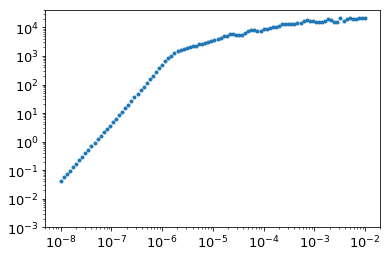

In [74]:
plt.errorbar(time_array,r_2, marker=".", linestyle="None")
plt.xscale("log")
plt.yscale("log")
plt.ylim(10**-3)

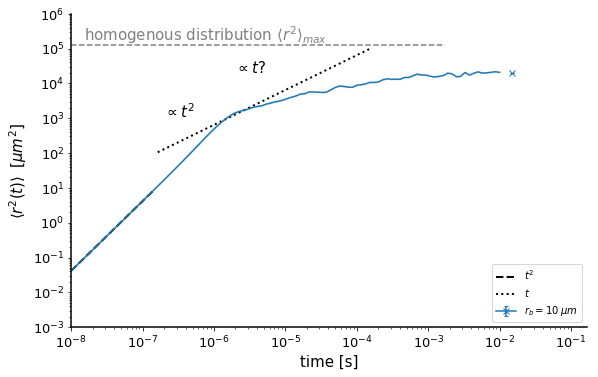

In [75]:
#color="lightblue", alpha=0.5
#color="bisque", alpha=0.5
#color="darkseagreen", alpha=0.4

plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)


from matplotlib import rc
fig, axes = plt.subplots(1,1, figsize=(8,5))  
plt.tight_layout()  
axes.set_xscale("log")
axes.set_yscale("log")
plt.xlim(left=10**-8, right=1.7*10**-1)
plt.ylim(0.001,10**6)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(1.5)


popt1,pcov1 = curve_fit(quad_func,time_array[0:10],r_2[0:10],p0=[5*10**15])
popt2,pcov2 = curve_fit(lin_func,time_array[30:40],r_2[30:40],p0=[5*10**15])
plt.plot(time_array[0:20],quad_func(time_array[0:20],*popt1), label=r"$t^2$", color="black", linestyle = "--", linewidth=2);
plt.plot(time_array[20:70],lin_func(time_array[20:70],*popt2), label=r"$t$", color="black", linestyle = ":", linewidth=2);



axes.fill_between(time_array, r_2-r_2_S, r_2+r_2_S, color="lightblue", alpha=0.5)
axes.plot(time_array,r_2);
axes.errorbar(time_array[-1]+time_array[-1]*0.5,r_2_inf, yerr= r_2_inf_S, marker ="x", label=r"$r_b=10 \;\mu m$",color = "C0",capsize=2)



axes.plot([10**-8,1.7*10**-3],[125000,125000],linestyle ="--", color= "grey")
axes.text(1.5*10**-8,170000,r"homogenous distribution $\langle r^2 \rangle_{max}$", color= "grey", fontsize=15)
axes.text(2*10**-7,10**3,r"$\propto t^2$", fontsize=15)
axes.text(2*10**-6,2*10**4,r"$\propto t ?$", fontsize=15)


axes.set_xlabel("time [s]", fontsize=15)
axes.set_ylabel(r"$\langle r^2(t) \rangle\;\;[\mu m^2]$", fontsize=15);
axes.legend();

In [17]:
R=np.sqrt(15000*5**2/0.5)
dens=np.array([0.2,0.05])
print(R)
N=dens*R**2/5**2
print(N)



866.0254037844386
[6000. 1500.]
